### MobileNetV3 designs

In [30]:
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras.models import Model

from keras.layers import Conv2D, BatchNormalization, ReLU, DepthwiseConv2D, Activation, Input, Add, UpSampling2D, Conv2DTranspose
from keras.layers import GlobalAveragePooling2D, Reshape, Dense, Multiply, Softmax, AveragePooling2D,Softmax

from keras.utils.generic_utils import get_custom_objects


In [2]:
#define hard swish activation function
def hard_swish(x):
    return x * tf.nn.relu6(x + 3) / 6
get_custom_objects().update({'custom_activation': Activation(hard_swish)})

#squeeze and excitation block
def sq_n_ex(input_, filters, r=4):

    '''
    param: input , ratio (r=4 in the paper)
    '''

    input_sNe_shape = (1, 1, input_.shape[-1]) 
    sNe_layer = GlobalAveragePooling2D()(input_)
    sNe_layer = Reshape(input_sNe_shape)(sNe_layer)
    
    #ratio is used only in the first fully connected layer
    sNe_layer = Dense(filters // r, activation='relu', kernel_initializer='he_normal', use_bias=False)(sNe_layer)  
    #hard sigmoid in the second FC
    sNe_layer = Dense(filters, activation='hard_sigmoid', kernel_initializer='he_normal', use_bias=False)(sNe_layer)
    
    return Multiply()([input_, sNe_layer])


#bottleneck block
def bottleneck(input_,kernel, exp_size, out_dim,SE=False,NL='RE',s=1):
    
    '''
    params: 
    - input: network input
    - kernel: kernel size
    - exp_size: expansion size
    - out_dim: layer output dimension
    - SE: booelan. If the "squeeze and excite" block is present
    - NL: Non linear function used. RE= relu or HS=hard swish
    - s: stride
    '''
    
    #first layer
    
    x = Conv2D(exp_size, (1, 1), strides=(1, 1), padding='same')(input_)
    x = BatchNormalization()(x)
    if NL == 'RE':
        x = ReLU()(x)
    elif NL == 'HS':
        x = Activation(hard_swish)(x)
        
    #second layer
      
    x = DepthwiseConv2D(kernel_size=kernel, strides=(s,s), depth_multiplier=1, padding='same')(x)
    x = BatchNormalization()(x)
    
            
    if NL == 'RE':
        x = ReLU()(x)
    elif NL == 'HS':
        x = Activation(hard_swish)(x)
    
    #if squeeze and excite is in the block
    if SE:
        x = sq_n_ex(x, exp_size)
        
    # third layer

    x = Conv2D(out_dim, (1, 1), strides=(1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    
    #residual just if stride=1 and same dimension of x and f(x) 
    if s == 1 and K.int_shape(input_)[-1] == out_dim:
        x = Add()([x,input_])
    
    return x
    

In [144]:
def build_Model():
    
    '''
    params:
    - in_dim: input dimension
    - n_class: number of classes for segmentation 
    - include_top: boolean. If true: include top
    - model_version: define model version of the mobilenet dfor features extraciton
    '''
    
    #input layer
    inputs = Input(shape=(256,256,3))
    
    x = Conv2D(16,(3,3), padding='same', strides=2)(inputs)
    x = BatchNormalization()(x)
    
    x= bottleneck(x, (3,3), 16,16 ,True,'RE',2)
    x_8 = bottleneck(x, (3,3), 72,24 ,False,'RE',2)
    x= bottleneck(x_8, (3,3), 88,24 ,False,'RE',1)

    x= bottleneck(x, (5,5), 96, 40 ,True,'HS',2)
    x= bottleneck(x, (5,5), 240,40 ,True,'HS',1)
    x= bottleneck(x, (5,5), 240,40 ,True,'HS',1)

    x= bottleneck(x, (5,5), 120,48 ,True,'HS',1)
    x= bottleneck(x, (5,5), 144,48 ,True,'HS',1)
    x= bottleneck(x, (5,5), 288,96 ,True,'HS',1)

    #x= bottleneck(x, (5,5), 576,96 ,True,'HS',1)
    #x= bottleneck(x, (5,5), 576,96 ,True,'HS',1)

    '''
    params:
    - base_model: mobileNetv3 already built
    - n_class: number of classes for segmentation 
    - model_version: define model version of the mobilenet dfor features extraciton
    if model_version=='large':
        layer_name_1_8='activation_1'
        layer_name_1_16='activation_13'
    else:    
        layer_name_1_8='activation_1'
        layer_name_1_16='activation_11'
    
    #1/8 resolution output
    out_1_8= base_model.get_layer(layer_name_1_8).output
    
    #1/16 resolution output
    out_1_16= base_model.get_layer(layer_name_1_16).output
    '''
    # branch1
    x1 = Conv2D(128, (1, 1))(x)
    x1 = BatchNormalization()(x1)
    x1 = Activation('relu')(x1)  
    
    # branch2
    #!!! important: the pool size and the strides of the next layer must be resized in case of input dimension
    #               equal to the one in the paper (224,224,3)
    
    #x2 = AveragePooling2D(pool_size=(49, 49), strides=(16, 20),data_format='channels_last')(out_1_16)
    x2 = GlobalAveragePooling2D()(x)
    x2 = Reshape((1, 1, int(x.shape[3])))(x2)
    x2 = Conv2D(128, (1, 1))(x2)
    x2 = Activation('sigmoid')(x2)
    x2 = UpSampling2D(size=(int(x1.shape[1]), int(x1.shape[2])),data_format='channels_last',interpolation="bilinear")(x2)
       
    # branch3
    #mod
    x3 = Conv2D(1, (1, 1))(x_8)
    
    # multiply
    m1 = Multiply()([x1, x2])
    #mod
    m1 = UpSampling2D(size=(2, 2),data_format='channels_last',interpolation="bilinear")(m1)
    m1 = Conv2D(1, (1, 1))(m1)
    #m1 = Conv2DTranspose(5, (2, 2), strides=(2, 2), padding='same')(m1)

    # add
    m2 = Add()([m1, x3])
    
    #adding UPsampling
    #!!! important: this upsampling is not part of the network presented in the paper
    #              but it's necessary for having output shape = input shape
    #m2 = UpSampling2D(size=(8, 8),data_format='channels_last',interpolation="bilinear")(m2)
    m2 = Conv2DTranspose(1, (8, 8), strides=(8, 8), padding='same')(m2)
    predictions = Conv2D(1, (1, 1), activation='sigmoid')(m2)

    #finally define the model
    model = Model(inputs=inputs, outputs=predictions)
    
    return model

In [129]:
model = build_Model()
model.summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_427 (Conv2D)             (None, 128, 128, 16) 448         input_17[0][0]                   
__________________________________________________________________________________________________
batch_normalization_477 (BatchN (None, 128, 128, 16) 64          conv2d_427[0][0]                 
__________________________________________________________________________________________________
conv2d_428 (Conv2D)             (None, 128, 128, 16) 272         batch_normalization_477[0][0]    
___________________________________________________________________________________________

In [5]:
import numpy as np
import cv2

In [6]:
#performance metric
smooth = 1.0
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

#loss function
def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + 100) / (sum_ - intersection + 100)
    return jac

In [125]:
with open('data_preprocessed_oversampled_v2.npy', 'rb') as f:
    x_train = np.load(f)
    y_train= np.load(f)
    x_val= np.load(f)
    y_val= np.load(f)
    x_test = np.load(f)
    y_test = np.load(f)

In [13]:
K.clear_session()
model = build_Model()
lr = 0.01
rms = keras.optimizers.RMSprop( learning_rate=lr, rho=0.9, momentum=0.0, decay=lr/25)
sgd = keras.optimizers.SGD(     learning_rate=lr, momentum=0.99, nesterov=True, decay=lr/50)
model.compile(optimizer=sgd, 
              loss=dice_coef_loss,
              metrics=[dice_coef, iou],
             )
print('# Fit model on training data')
history = model.fit(
            x_train, 
            y_train,
            validation_data=(x_val, y_val),
            batch_size=1,
            epochs=1,
            shuffle=True,
            #callbacks=[],
    )

# Fit model on training data
Train on 4634 samples, validate on 659 samples
Epoch 1/1
3282/4634 [====================>.........] - ETA: 4:36 - loss: 0.5710 - dice_coef: 0.4290 - iou: 0.5029

KeyboardInterrupt: 

In [119]:
np.full(1, True)
ct = 0
ex = np.full(len(x_train), True)
for _ in range(len(x_train)):
  if x_train[_].max() < 0.1:
    ct +=1
    ex[_] = False
print(ct)

171


In [121]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Conv2D, BatchNormalization, ReLU, DepthwiseConv2D, Activation, Input, Add, UpSampling2D, Conv2DTranspose
from keras.layers import GlobalAveragePooling2D, Reshape, Dense, Multiply, Softmax, AveragePooling2D,Softmax
from keras.utils.generic_utils import get_custom_objects
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

#performance metric
smooth = 1.0
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
#loss function
def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)
def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + 100) / (sum_ - intersection + 100)
    return jac

#define hard swish activation function
def hard_swish(x):
    return x * tf.nn.relu6(x + 3) / 6
get_custom_objects().update({'custom_activation': Activation(hard_swish)})

#squeeze and excitation block
def sq_n_ex(input_, filters, r=4):

    '''
    param: input , ratio (r=4 in the paper)
    '''

    input_sNe_shape = (1, 1, input_.shape[-1]) 
    sNe_layer = GlobalAveragePooling2D()(input_)
    sNe_layer = Reshape(input_sNe_shape)(sNe_layer)
    
    #ratio is used only in the first fully connected layer
    sNe_layer = Dense(filters // r, activation='relu', kernel_initializer='he_normal', use_bias=False)(sNe_layer)  
    #hard sigmoid in the second FC
    sNe_layer = Dense(filters, activation='hard_sigmoid', kernel_initializer='he_normal', use_bias=False)(sNe_layer)
    
    return Multiply()([input_, sNe_layer])

#bottleneck block
def bottleneck(input_,kernel, exp_size, out_dim,SE=False,NL='RE',s=1):
    
    '''
    params: 
    - input: network input
    - kernel: kernel size
    - exp_size: expansion size
    - out_dim: layer output dimension
    - SE: booelan. If the "squeeze and excite" block is present
    - NL: Non linear function used. RE= relu or HS=hard swish
    - s: stride
    '''
    
    #first layer
    
    x = Conv2D(exp_size, (1, 1), strides=(1, 1), padding='same')(input_)
    x = BatchNormalization()(x)
    if NL == 'RE':
        x = ReLU()(x)
    elif NL == 'HS':
        x = Activation(hard_swish)(x)
        
    #second layer
      
    x = DepthwiseConv2D(kernel_size=kernel, strides=(s,s), depth_multiplier=1, padding='same')(x)
    x = BatchNormalization()(x)
    
            
    if NL == 'RE':
        x = ReLU()(x)
    elif NL == 'HS':
        x = Activation(hard_swish)(x)
    
    #if squeeze and excite is in the block
    if SE:
        x = sq_n_ex(x, exp_size)
        
    # third layer

    x = Conv2D(out_dim, (1, 1), strides=(1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    
    #residual just if stride=1 and same dimension of x and f(x) 
    if s == 1 and K.int_shape(input_)[-1] == out_dim:
        x = Add()([x,input_])
    
    return x

def build_Model(multiplier=1):
    
    '''
    params:
    - in_dim: input dimension
    - n_class: number of classes for segmentation 
    - include_top: boolean. If true: include top
    - model_version: define model version of the mobilenet dfor features extraciton
    '''
    
    #input layer
    inputs = Input(shape=(256,256,3))
    
    x_2 = Conv2D(16,(3,3), padding='same', strides=2)(inputs)
    x = BatchNormalization()(x_2)
    
    x_4 = bottleneck(x, (3,3), multiplier*16,16 ,True,'RE',2)
    x_8 = bottleneck(x_4, (3,3), multiplier* 72,24 ,False,'RE',2)
    x = bottleneck(x_8, (3,3), multiplier* 88,24 ,False,'RE',1)

    x_16 = bottleneck(x, (5,5), multiplier*96, 40 ,True,'HS',2)
    x= bottleneck(x_16, (5,5), multiplier*240,40 ,True,'HS',1)
    x= bottleneck(x, (5,5), multiplier*240,40 ,True,'HS',1)

    x= bottleneck(x, (5,5), multiplier*120,48 ,True,'HS',1)
    x= bottleneck(x, (5,5), multiplier*144,48 ,True,'HS',1)
    x= bottleneck(x, (5,5), multiplier*288,96 ,True,'HS',1)
    
    x= bottleneck(x, (5,5), 576,96 ,True,'HS',1)

    #LR-ASPP
    # branch1
    x1 = Conv2D(128, (1, 1))(x)
    x1 = BatchNormalization()(x1)
    x1 = Activation('relu')(x1)  
    # branch2    
    #x2 = AveragePooling2D(pool_size=(49, 49), strides=(16, 20),data_format='channels_last')(out_1_16)
    x2 = GlobalAveragePooling2D()(x)
    x2 = Reshape((1, 1, int(x.shape[3])))(x2)
    x2 = Conv2D(128, (1, 1))(x2)
    x2 = Activation('sigmoid')(x2)
    x2 = UpSampling2D(size=(int(x1.shape[1]), int(x1.shape[2])),data_format='channels_last',interpolation="bilinear")(x2)
       
    # branch3
    x_2 = UpSampling2D(size=(2, 2),data_format='channels_last',interpolation="bilinear")(x_2)
    x_2 = Conv2D(1, (1, 1))(x_2)
    x_4 = UpSampling2D(size=(4, 4),data_format='channels_last',interpolation="bilinear")(x_4)
    x_4 = Conv2D(1, (1, 1))(x_4)
    x_8 = UpSampling2D(size=(8, 8),data_format='channels_last',interpolation="bilinear")(x_8)
    x_8 = Conv2D(1, (1, 1))(x_8)
    x_16 = UpSampling2D(size=(16, 16),data_format='channels_last',interpolation="bilinear")(x_16)
    x_16 = Conv2D(1, (1, 1))(x_16)
    x3 = Add()([x_2, x_4, x_8, x_16])
    x3 = Conv2D(1, (3, 3), padding='same')(x3)
    x3 = Conv2D(1, (3, 3), padding='same')(x3)
    
    # multiply
    m1 = Multiply()([x1, x2])
    m1 = UpSampling2D(size=(16, 16),data_format='channels_last',interpolation="bilinear")(m1)
    m1 = Conv2D(1, (1, 1))(m1)

    # add
    m2 = Add()([m1, x3])
    
    #adding UPsampling
    #!!! important: this upsampling is not part of the network presented in the paper
    #              but it's necessary for having output shape = input shape
    #m2 = UpSampling2D(size=(8, 8),data_format='channels_last',interpolation="bilinear")(m2)
    #m2 = Conv2DTranspose(1, (4, 4), strides=(4, 4), padding='same')(m2)
    predictions = Conv2D(1, (1, 1), activation='sigmoid')(m2)

    #finally define the model
    model = Model(inputs=inputs, outputs=predictions)
    
    return model

In [160]:
#performance metric
smooth = 1.0
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
#loss function
def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)
def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + 100) / (sum_ - intersection + 100)
    return jac

#define hard swish activation function
def hard_swish(x):
    return x * tf.nn.relu6(x + 3) / 6
get_custom_objects().update({'custom_activation': Activation(hard_swish)})

#squeeze and excitation block
def sq_n_ex(input_, filters, r=4):

    '''
    param: input , ratio (r=4 in the paper)
    '''

    input_sNe_shape = (1, 1, input_.shape[-1]) 
    sNe_layer = GlobalAveragePooling2D()(input_)
    sNe_layer = Reshape(input_sNe_shape)(sNe_layer)
    
    #ratio is used only in the first fully connected layer
    sNe_layer = Dense(filters // r, activation='relu', kernel_initializer='he_normal', use_bias=False)(sNe_layer)  
    #hard sigmoid in the second FC
    sNe_layer = Dense(filters, activation='hard_sigmoid', kernel_initializer='he_normal', use_bias=False)(sNe_layer)
    
    return Multiply()([input_, sNe_layer])

#bottleneck block
def bottleneck(input_,kernel, exp_size, out_dim,SE=False,NL='RE',s=1, dil_rate=1):
    
    '''
    params: 
    - input: network input
    - kernel: kernel size
    - exp_size: expansion size
    - out_dim: layer output dimension
    - SE: booelan. If the "squeeze and excite" block is present
    - NL: Non linear function used. RE= relu or HS=hard swish
    - s: stride
    '''
    
    #first layer
    
    x = Conv2D(exp_size, (1, 1), strides=(1, 1), padding='same')(input_)
    x = BatchNormalization()(x)
    if NL == 'RE':
        x = ReLU()(x)
    elif NL == 'HS':
        x = Activation(hard_swish)(x)
        
    #second layer
      
    x = DepthwiseConv2D(kernel_size=kernel, strides=(s,s), dilation_rate=(dil_rate,dil_rate), depth_multiplier=1, padding='same')(x)
    x = BatchNormalization()(x)
    
            
    if NL == 'RE':
        x = ReLU()(x)
    elif NL == 'HS':
        x = Activation(hard_swish)(x)
    
    #if squeeze and excite is in the block
    if SE:
        x = sq_n_ex(x, exp_size)
        
    # third layer

    x = Conv2D(out_dim, (1, 1), strides=(1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    
    #residual just if stride=1 and same dimension of x and f(x) 
    if s == 1 and K.int_shape(input_)[-1] == out_dim:
        x = Add()([x,input_])
    
    return x

def build_Model(multiplier=1):
    
    '''
    params:
    - in_dim: input dimension
    - n_class: number of classes for segmentation 
    - include_top: boolean. If true: include top
    - model_version: define model version of the mobilenet dfor features extraciton
    '''
    
    #input layer
    inputs = Input(shape=(256,256,3))
    
    x_2 = Conv2D(16,(3,3), padding='same', strides=2)(inputs)
    x = BatchNormalization()(x_2)
    
    x_4 = bottleneck(x, (3,3), multiplier*16,16 ,True,'RE',2)
    x_8 = bottleneck(x_4, (3,3), multiplier* 72,24 ,False,'RE',2)
    x = bottleneck(x_8, (3,3), multiplier* 88,24 ,False,'RE',1)

    x_16 = bottleneck(x, (5,5), multiplier*96, 40 ,True,'HS',2)
    x= bottleneck(x_16, (5,5), multiplier*240,40 ,True,'HS',1)
    x= bottleneck(x, (5,5), multiplier*240,40 ,True,'HS',1)

    x= bottleneck(x, (5,5), multiplier*120,48 ,True,'HS',1)
    x= bottleneck(x, (5,5), multiplier*144,48 ,True,'HS',1)
    x= bottleneck(x, (5,5), multiplier*288,96 ,True,'HS',1, dil_rate=2)

    #LR-ASPP
    # branch1
    x1 = Conv2D(128, (1, 1))(x)
    x1 = BatchNormalization()(x1)
    x1 = Activation('relu')(x1)  
    # branch2    
    #x2 = AveragePooling2D(pool_size=(49, 49), strides=(16, 20),data_format='channels_last')(out_1_16)
    x2 = GlobalAveragePooling2D()(x)
    x2 = Reshape((1, 1, int(x.shape[3])))(x2)
    x2 = Conv2D(128, (1, 1))(x2)
    x2 = Activation('sigmoid')(x2)
    x2 = UpSampling2D(size=(int(x1.shape[1]), int(x1.shape[2])),data_format='channels_last',interpolation="bilinear")(x2)
       
    # branch3
    x_2 = UpSampling2D(size=(2, 2),data_format='channels_last',interpolation="bilinear")(x_2)
    x_2 = Conv2D(1, (1, 1))(x_2)
    x_4 = UpSampling2D(size=(4, 4),data_format='channels_last',interpolation="bilinear")(x_4)
    x_4 = Conv2D(1, (1, 1))(x_4)
    x_8 = UpSampling2D(size=(8, 8),data_format='channels_last',interpolation="bilinear")(x_8)
    x_8 = Conv2D(1, (1, 1))(x_8)
    x_16 = UpSampling2D(size=(16, 16),data_format='channels_last',interpolation="bilinear")(x_16)
    x_16 = Conv2D(1, (1, 1))(x_16)
    x3 = Add()([x_2, x_4, x_8, x_16])
    x3 = Conv2D(1, (3, 3), padding='same')(x3)
    x3 = Conv2D(1, (3, 3), padding='same')(x3)
    
    # multiply
    m1 = Multiply()([x1, x2])
    m1 = UpSampling2D(size=(16, 16),data_format='channels_last',interpolation="bilinear")(m1)
    m1 = Conv2D(1, (1, 1))(m1)

    # add
    m2 = Add()([m1, x3])
    
    #adding UPsampling
    #!!! important: this upsampling is not part of the network presented in the paper
    #              but it's necessary for having output shape = input shape
    #m2 = UpSampling2D(size=(8, 8),data_format='channels_last',interpolation="bilinear")(m2)
    #m2 = Conv2DTranspose(1, (4, 4), strides=(4, 4), padding='same')(m2)
    predictions = Conv2D(1, (1, 1), activation='sigmoid')(m2)

    #finally define the model
    model = Model(inputs=inputs, outputs=predictions)
    
    return model

In [154]:
#performance metric
smooth = 1.0
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
#loss function
def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)
def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + 100) / (sum_ - intersection + 100)
    return jac

#define hard swish activation function
def hard_swish(x):
    return x * tf.nn.relu6(x + 3) / 6
get_custom_objects().update({'custom_activation': Activation(hard_swish)})

#squeeze and excitation block
def sq_n_ex(input_, filters, r=4):

    '''
    param: input , ratio (r=4 in the paper)
    '''

    input_sNe_shape = (1, 1, input_.shape[-1]) 
    sNe_layer = GlobalAveragePooling2D()(input_)
    sNe_layer = Reshape(input_sNe_shape)(sNe_layer)
    
    #ratio is used only in the first fully connected layer
    sNe_layer = Dense(filters // r, activation='relu', kernel_initializer='he_normal', use_bias=False)(sNe_layer)  
    #hard sigmoid in the second FC
    sNe_layer = Dense(filters, activation='hard_sigmoid', kernel_initializer='he_normal', use_bias=False)(sNe_layer)
    
    return Multiply()([input_, sNe_layer])

#bottleneck block
def bottleneck(input_,kernel, exp_size, out_dim,SE=False,NL='RE',s=1, dil_rate=1):
    
    '''
    params: 
    - input: network input
    - kernel: kernel size
    - exp_size: expansion size
    - out_dim: layer output dimension
    - SE: booelan. If the "squeeze and excite" block is present
    - NL: Non linear function used. RE= relu or HS=hard swish
    - s: stride
    '''
    
    #first layer
    
    x = Conv2D(exp_size, (1, 1), strides=(1, 1), padding='same')(input_)
    x = BatchNormalization()(x)
    if NL == 'RE':
        x = ReLU()(x)
    elif NL == 'HS':
        x = Activation(hard_swish)(x)
        
    #second layer
      
    x = DepthwiseConv2D(kernel_size=kernel, strides=(s,s), dilation_rate=(dil_rate,dil_rate), depth_multiplier=1, padding='same')(x)
    x = BatchNormalization()(x)
    
            
    if NL == 'RE':
        x = ReLU()(x)
    elif NL == 'HS':
        x = Activation(hard_swish)(x)
    
    #if squeeze and excite is in the block
    if SE:
        x = sq_n_ex(x, exp_size)
        
    # third layer

    x = Conv2D(out_dim, (1, 1), strides=(1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    
    #residual just if stride=1 and same dimension of x and f(x) 
    if s == 1 and K.int_shape(input_)[-1] == out_dim:
        x = Add()([x,input_])
    
    return x

def build_Model(multiplier=1):
    
    '''
    params:
    - in_dim: input dimension
    - n_class: number of classes for segmentation 
    - include_top: boolean. If true: include top
    - model_version: define model version of the mobilenet dfor features extraciton
    '''
    
    #input layer
    inputs = Input(shape=(256,256,3))
    
    x_2 = Conv2D(16,(3,3), padding='same', strides=2)(inputs)
    x = BatchNormalization()(x_2)
    
    x_4 = bottleneck(x, (3,3), multiplier*16,16 ,True,'RE',2)
    x_8 = bottleneck(x_4, (3,3), multiplier* 72,24 ,False,'RE',2)
    x = bottleneck(x_8, (3,3), multiplier* 88,24 ,False,'RE',1)

    x_16 = bottleneck(x, (5,5), multiplier*96, 40 ,True,'HS',2)
    x= bottleneck(x_16, (5,5), multiplier*240,40 ,True,'HS',1)
    x= bottleneck(x, (5,5), multiplier*240,40 ,True,'HS',1)

    x= bottleneck(x, (5,5), multiplier*120,48 ,True,'HS',1)
    x= bottleneck(x, (5,5), multiplier*144,48 ,True,'HS',1)
    x= bottleneck(x, (5,5), multiplier*288,96 ,True,'HS',1, dil_rate=2)

    #LR-ASPP
    # branch1
    x1 = Conv2D(128, (1, 1))(x)
    x1 = BatchNormalization()(x1)
    x1 = Activation('relu')(x1)  
    # branch2    
    #x2 = AveragePooling2D(pool_size=(49, 49), strides=(16, 20),data_format='channels_last')(out_1_16)
    x2 = GlobalAveragePooling2D()(x)
    x2 = Reshape((1, 1, int(x.shape[3])))(x2)
    x2 = Conv2D(128, (1, 1))(x2)
    x2 = Activation('sigmoid')(x2)
    x2 = UpSampling2D(size=(int(x1.shape[1]), int(x1.shape[2])),data_format='channels_last',interpolation="bilinear")(x2)
       
    # branch3
    '''
    x_2 = UpSampling2D(size=(2, 2),data_format='channels_last',interpolation="bilinear")(x_2)
    x_2 = Conv2D(1, (1, 1))(x_2)
    x_4 = UpSampling2D(size=(4, 4),data_format='channels_last',interpolation="bilinear")(x_4)
    x_4 = Conv2D(1, (1, 1))(x_4)
    x_8 = UpSampling2D(size=(8, 8),data_format='channels_last',interpolation="bilinear")(x_8)
    x_8 = Conv2D(1, (1, 1))(x_8)
    x_16 = UpSampling2D(size=(16, 16),data_format='channels_last',interpolation="bilinear")(x_16)
    x_16 = Conv2D(1, (1, 1))(x_16)
    x3 = Add()([x_2, x_4, x_8, x_16])
    x3 = Conv2D(1, (3, 3), padding='same')(x3)
    x3 = Conv2D(1, (3, 3), padding='same')(x3)
    '''
    x3 = Conv2D(1, (1, 1))(x_8)

    # multiply
    m1 = Multiply()([x1, x2])
    m1 = UpSampling2D(size=(2, 2),data_format='channels_last',interpolation="bilinear")(m1)
    m1 = Conv2D(1, (1, 1))(m1)

    # add
    m2 = Add()([m1, x3])
    
    #adding UPsampling
    #!!! important: this upsampling is not part of the network presented in the paper
    #              but it's necessary for having output shape = input shape
    m2 = UpSampling2D(size=(8, 8),data_format='channels_last',interpolation="bilinear")(m2)
    #m2 = Conv2DTranspose(1, (4, 4), strides=(4, 4), padding='same')(m2)
    predictions = Conv2D(1, (1, 1), activation='sigmoid')(m2)

    #finally define the model
    model = Model(inputs=inputs, outputs=predictions)
    
    return model

In [136]:
model = build_Model()

In [123]:
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_396 (Conv2D)             (None, 128, 128, 16) 448         input_16[0][0]                   
__________________________________________________________________________________________________
batch_normalization_445 (BatchN (None, 128, 128, 16) 64          conv2d_396[0][0]                 
__________________________________________________________________________________________________
conv2d_397 (Conv2D)             (None, 128, 128, 16) 272         batch_normalization_445[0][0]    
___________________________________________________________________________________________

In [124]:
x_train.max()

255.0

### TEST

In [126]:
#global standardization 
mean = np.mean(x_train)
std = np.std(x_train)
x_train-= mean
x_train /= std

x_val -= mean  #using training mean and std also for val data standardization
x_val /= std

x_test -= mean  #using training mean and std also for test data standardization
x_test /= std

In [161]:
#using pre-trained U-Net for predictions of FLAIR segmentation
weights_path = './weights2/MNETV3_mod_brainMRI_trial3.hdf5'

def predict(data):
    # load model with weights 
    model = build_Model()
    model.load_weights(weights_path)

    # make predictions
    imgs_mask_pred = model.predict(data, verbose=1)

    return imgs_mask_pred

imgs_mask_pred_val = predict(x_val)
imgs_mask_pred_test = predict(x_test)


367/367 [==============================] - 40s 110ms/step


In [162]:
#val accuracy
y_pred = imgs_mask_pred_val.copy()
thresh = 0.5
y_pred[y_pred<=thresh] = 0
y_pred[y_pred>thresh] = 1

print(dice_coefficient(y_pred, y_val))
print(dice_coeff(y_val, y_pred))

0.8405526699521133
tf.Tensor(0.84057003, shape=(), dtype=float32)


In [164]:
#test accuracy
y_pred = imgs_mask_pred_test.copy()
thresh = 0.5
y_pred[y_pred<=thresh] = 0
y_pred[y_pred>thresh] = 1

print(dice_coefficient(y_pred, y_test))
#print(dice_coeff(y_val, y_pred))

0.8526961815273228


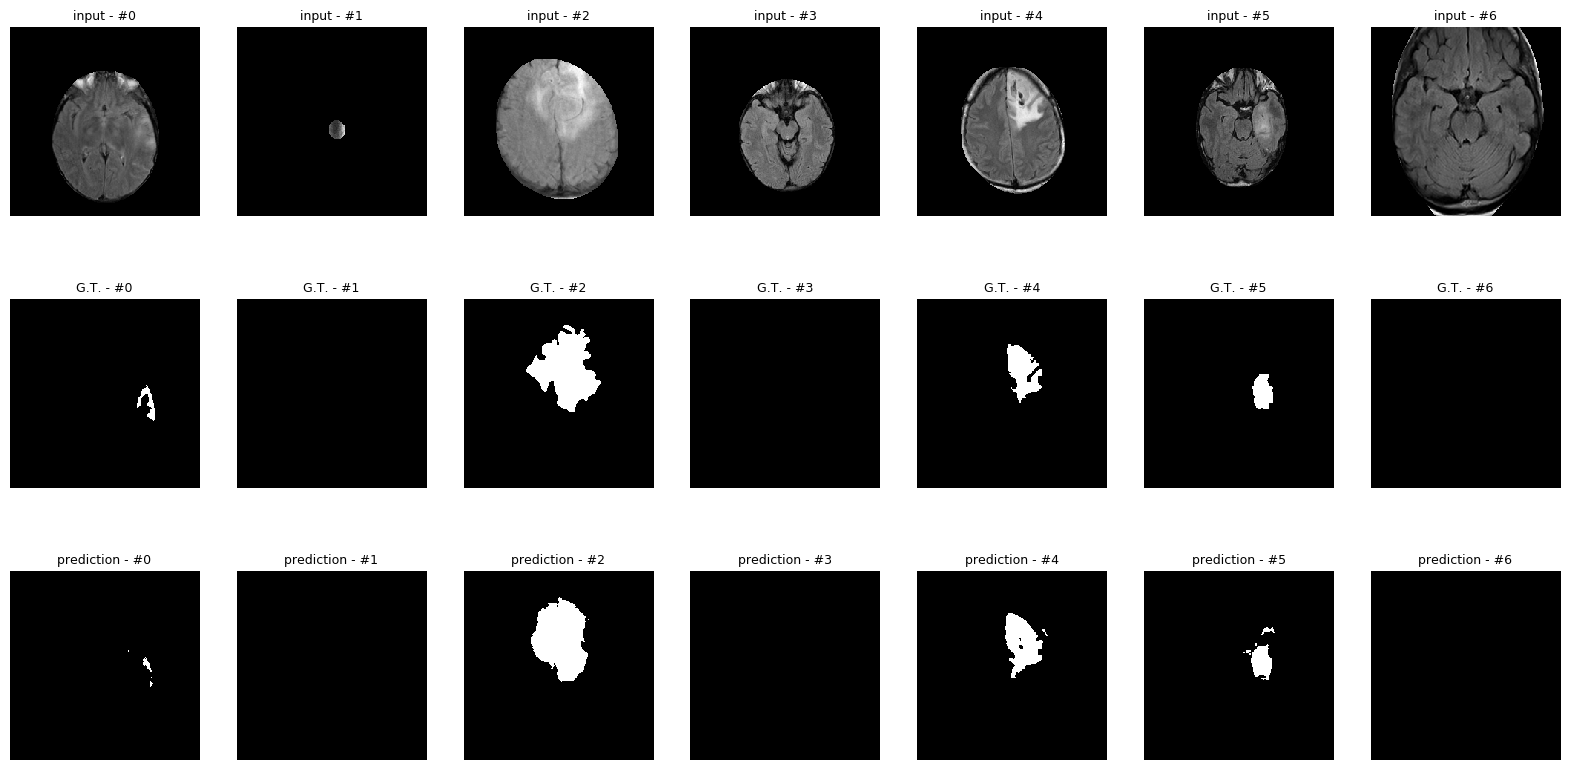

In [169]:
nrow = 7
nrep = 1
offset = 0
fig, axs = plt.subplots(3*nrep,nrow,figsize=(20,10*nrep))
for i in range(nrep):
    for _ in range(nrow): axs[0+3*i,_].imshow(x_test[(_+nrow*i)+offset,:,:,1], cmap='gray'), axs[0+3*i,_].axis('off'), axs[0+3*i,_].set_title(f'input - #{(_+nrow*i)+offset}', fontsize=9)
    for _ in range(nrow): axs[1+3*i,_].imshow((y_test[(_+nrow*i)+offset,:,:,0]), cmap='gray'), axs[1+3*i,_].axis('off'), axs[1+3*i,_].set_title(f'G.T. - #{(_+nrow*i)+offset}',fontsize=9)
    for _ in range(nrow): axs[2+3*i,_].imshow(y_pred[(_+nrow*i)+offset,:,:,0], cmap='gray'), axs[2+3*i,_].axis('off'), axs[2+3*i,_].set_title(f'prediction - #{(_+nrow*i)+offset}',fontsize=9)
    
plt.savefig('predictions.png')

In [155]:
#using pre-trained U-Net for predictions of FLAIR segmentation
weights_path = './weights2/FINAL_MNETV3_stand.hdf5'

def predict(data):
    # load model with weights 
    model = build_Model()
    model.load_weights(weights_path)

    # make predictions
    imgs_mask_pred = model.predict(data, verbose=1)

    return imgs_mask_pred

imgs_mask_pred_val = predict(x_val)
imgs_mask_pred_test = predict(x_test)


367/367 [==============================] - 19s 51ms/step


In [148]:
#val accuracy
y_pred = imgs_mask_pred_val.copy()
thresh = 0.5
y_pred[y_pred<=thresh] = 0
y_pred[y_pred>thresh] = 1

print(dice_coefficient(y_pred, y_val))
print(dice_coeff(y_val, y_pred))

0.8349240738359333
tf.Tensor(0.83494204, shape=(), dtype=float32)


In [149]:
#val accuracy
y_pred = imgs_mask_pred_test.copy()
thresh = 0.5
y_pred[y_pred<=thresh] = 0
y_pred[y_pred>thresh] = 1

print(dice_coefficient(y_pred, y_test))
print(dice_coeff(y_val, y_pred))

0.8476483090001848


InvalidArgumentError: Incompatible shapes: [43188224] vs. [24051712] [Op:Mul] name: mul/

In [140]:
def dice_coefficient(prediction, ground_truth):
    prediction = np.round(prediction).astype(int)
    ground_truth = np.round(ground_truth).astype(int)
    np.sum(prediction[ground_truth == 1])
    return (
        np.sum(prediction[ground_truth == 1])
        * 2.0
        / (np.sum(prediction) + np.sum(ground_truth))
    )

def dice_coeff(ytrue, ypred, smooth=100):
    ytrue_flat = K.flatten(ytrue)
    ypred_flat = K.flatten(ypred)
    intersection = K.sum(ytrue_flat * ypred_flat)
    total_area = K.sum(ytrue_flat) + K.sum(ypred_flat)
    return (2*intersection + smooth)/(total_area + smooth)

def dice_coeff_loss(ytrue,ypred, smooth=100):
    return 1-dice_coeff(ytrue, ypred, smooth)

def iou_coeff(ytrue, ypred, smooth=100):
    intersection = K.sum(ytrue * ypred)
    union = K.sum(ytrue + ypred) - intersection
    return (intersection + smooth)/(union + smooth)